In [7]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict

In [8]:
# !pip install langgraph

In [ ]:
class Task(TypedDict):
    transcript:str
    works:str
    

In [48]:
from langchain_perplexity import ChatPerplexity
from dotenv import load_dotenv
load_dotenv()

llm=ChatPerplexity(model='sonar-pro')

In [21]:
def read_transcript(state:Task):
    return state

In [35]:
from langchain.prompts import ChatPromptTemplate
from langchain.output_parsers import PydanticOutputParser,OutputFixingParser
from pydantic import BaseModel
from typing import Dict

class TaskModel(BaseModel):
    ans:Dict[str,str]
    
parser=PydanticOutputParser(pydantic_object=TaskModel)

op_fixing_parser= OutputFixingParser.from_llm(parser=parser,llm=llm)

prompt=ChatPromptTemplate([("system", "You are a helpful assistant. Extract employee-task pairs from the following meeting transcript. Output only a JSON object with employee names as keys and their assigned task as values. Do not add any text outside the JSON and follow the following instructions {format_instructions}"),("human","{transcript}")])

prompt=prompt.partial(format_instructions=parser.get_format_instructions())



chain=prompt|llm|op_fixing_parser

def separate_tasks(state):
    result=chain.invoke({"transcript":state["transcript"]})
    state['works']=result.ans
    return state

In [72]:
import os
from jira import JIRA


def create_jira_tasks(state: Task):

    JIRA_EMAIL = os.getenv("JIRA_EMAIL")
    JIRA_API_TOKEN = os.getenv("JIRA_API_TOKEN")
    JIRA_URL = os.getenv("JIRA_URL")
    JIRA_PROJECT_KEY = os.getenv("JIRA_PROJECT_KEY")

    jira = JIRA(
        server=JIRA_URL,
        basic_auth=(JIRA_EMAIL, JIRA_API_TOKEN)
    )
    

    task_dict = state['works']
    issue_keys = {}

    for person, task in task_dict.items():
        users = jira.search_users(query=person)
        if users:
            account_id = users[0].accountId
        else:
            account_id = None
        issue_dict = {
            'project': {'key': JIRA_PROJECT_KEY},
            'summary': task.capitalize(),
            'description': f"Task assigned to {person}: {task}",
            'issuetype': {'name': 'Task'},
        }
        
        if account_id:
            issue_dict['assignee'] = {'accountId': account_id}
        try:
            issue = jira.create_issue(fields=issue_dict)
            issue_keys[person] = issue.key
        except Exception as e:
            issue_keys[person] = f"Error: {str(e)}"

    state["jira_issues"] = issue_keys
    return state



In [73]:
graph=StateGraph(Task)

graph.add_node("read_transcript",read_transcript)

graph.add_node("separate_tasks",separate_tasks)

graph.add_node("create_jira_tasks",create_jira_tasks)

graph.add_edge(START,"read_transcript")

graph.add_edge("read_transcript","separate_tasks")

graph.add_edge("separate_tasks","create_jira_tasks")

graph.add_edge("create_jira_tasks",END)


workflow=graph.compile()

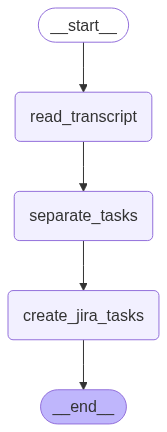

In [ ]:
# workflow  

In [77]:
initial_state={'transcript':"max will continue hi shalvi good moringng, good morning team,yesterday i have worked on building some llms and today i will continue building them . ok max now yogit will continue hi shalvi  yesterday i have dealt with the bugs in the production and today i am planning on dokerizing the ondc application","works":""}
workflow.invoke(initial_state)

{'transcript': 'max will continue hi shalvi good moringng, good morning team,yesterday i have worked on building some llms and today i will continue building them . ok max now yogit will continue hi shalvi  yesterday i have dealt with the bugs in the production and today i am planning on dokerizing the ondc application',
 'works': {'Max': 'Continue building some LLMs',
  'Yogit': 'Dockerizing the ONDC application'}}

In [76]:
# !pip install jira
# !pip install os

In [67]:
users = jira.search_users(query='yogit')
if users:
    account_id = users[0].accountId
else:
    account_id = None
for i in users:
    print(i.displayName, i.accountId)

yogit.gurram 712020:c02dd8be-4d03-4c6b-a6fa-38059e4775de
